In [ ]:
import pandas as pd

# Read the CSV
individuals_df_new = pd.read_csv('random_individuals.txt')import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, brier_score_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42) 
N = 300

data = {
    "age": np.random.randint(12, 55, size=N),
    "gender": np.random.choice(["male", "female", "other"], size=N),
    "device_type": np.random.choice(["mobile", "laptop", "tablet", "tv"], size=N),
    "daily_hours": np.round(np.random.uniform(1, 12, size=N), 1),
    "session_length": np.round(np.random.uniform(10, 180, size=N), 1),
    "breaks": np.random.randint(0, 6, size=N),
    "font_size": np.random.choice(["small", "medium", "large"], size=N),
    "brightness": np.random.choice(["low", "medium", "high"], size=N),
    "dark_mode": np.random.choice(["yes", "no"], size=N),
    "outdoor_time": np.round(np.random.uniform(0, 3, size=N), 1),
    "viewing_distance": np.random.uniform(20, 80, size=N),
    "screen_height": np.random.choice(["below_eye", "eye_level", "above_eye"], size=N),
    "lighting": np.random.choice(["dim", "normal", "bright"], size=N),
    "sleep_quality": np.random.randint(1, 6, size=N),
    "headache_freq": np.random.randint(1, 6, size=N),
    "eyestrain_freq": np.random.randint(1, 6, size=N),
}

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
def vision_status(row):
    score = 0
    score += row["daily_hours"] > 6
    score += row["session_length"] > 60
    score += row["outdoor_time"] < 1
    score += row["brightness"] == "high"
    score += row["dark_mode"] == "no"
    score += row["eyestrain_freq"] >= 3
    score += row["age"] > 35
    if score >= 5:
        return "severe"
    elif score >= 3:
        return "moderate"
    elif score >= 2:
        return "mild"
    else:
        return "normal"

In [ ]:
df_new = pd.concat([df_new, individuals_df_new], ignore_index=True)
# Now use df_new_new instead of df_new for training
df_new["vision_status"] = df_new.apply(vision_status, axis=1)
df_new["vision_status_bin"] = df_new["vision_status"].map(lambda x: "impaired" if x in ["mild", "moderate", "severe"] else "normal")

cat_cols = ["gender", "device_type", "font_size", "brightness", "dark_mode",
            "screen_height", "lighting"]
label_encoders = {}
# Assuming you already have label_encoders, scaler, cat_cols, num_cols, and feature_cols defined in your notebook

# Encode categorical columns
for col in cat_cols:
    le = label_encoders[col]
    individuals_df_new[col] = le.transform(individuals_df_new[col].astype(str))

# Scale numerical columns
individuals_df_new[num_cols] = scaler.transform(individuals_df_new[num_cols])

# Create target column if needed (example: manual labeling or prediction)


feature_cols = ["age", "gender", "device_type", "daily_hours", "session_length", "breaks",
                "font_size", "brightness", "dark_mode", "outdoor_time",
                "viewing_distance", "screen_height", "lighting", "sleep_quality",
                "headache_freq", "eyestrain_freq"]

scaler = StandardScaler()

num_cols = ["age", "daily_hours", "session_length", "breaks", "outdoor_time",
            "viewing_distance", "sleep_quality", "headache_freq", "eyestrain_freq"]
df_new[num_cols] = scaler.fit_transform(df_new[num_cols])

In [ ]:
target_bin = df_new["vision_status_bin"].map({"normal": 0, "impaired": 1})

ordinal_map = {"normal": 0, "mild": 1, "moderate": 2, "severe": 3}
target_ord = df_new["vision_status"].map(ordinal_map)

X = df_new[feature_cols]
y_bin = target_bin
y_ord = target_ord

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, stratify=y_bin, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_lr))
print("AUROC:", roc_auc_score(y_test, y_prob_lr))
print("Brier Score:", brier_score_loss(y_test, y_prob_lr))
print()

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.95      0.96      0.96        56

    accuracy                           0.92        60
   macro avg       0.64      0.61      0.62        60
weighted avg       0.91      0.92      0.91        60

AUROC: 0.9241071428571429
Brier Score: 0.05463334667353616



In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print("AUROC:", roc_auc_score(y_test, y_prob_xgb))
print("Brier Score:", brier_score_loss(y_test, y_prob_xgb))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.97      1.00      0.98        56

    accuracy                           0.97        60
   macro avg       0.98      0.75      0.82        60
weighted avg       0.97      0.97      0.96        60

AUROC: 0.9866071428571428
Brier Score: 0.029305114738783077


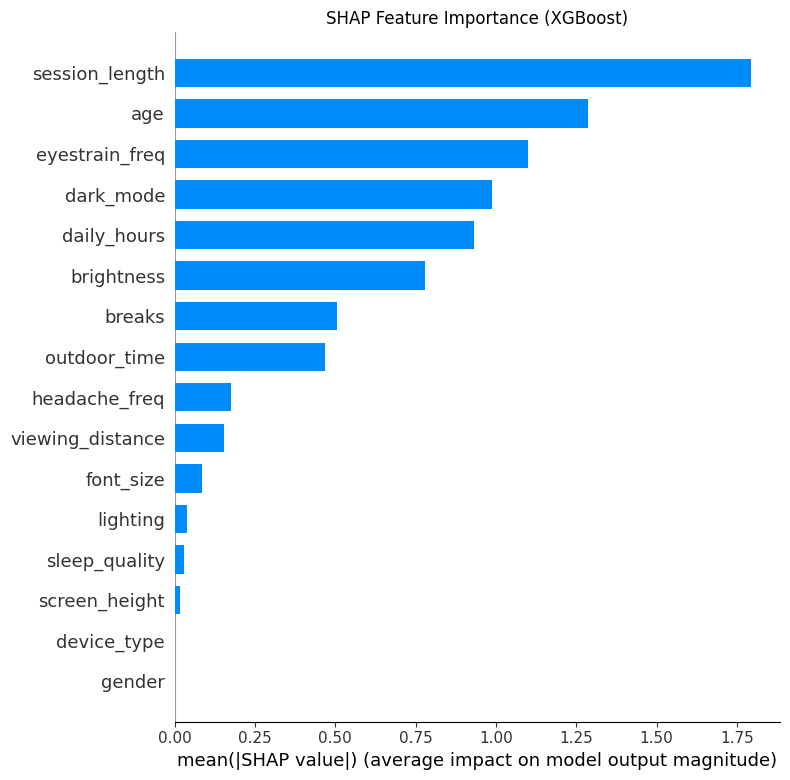

In [ ]:
import warnings

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
plt.title("SHAP Feature Importance (XGBoost)")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    shap.summary_plot(shap_values, X_test, show=False, plot_type="bar")
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y_ord, test_size=0.2, stratify=y_ord, random_state=42)
xgb_ord = XGBClassifier(eval_metric='mlogloss', objective='multi:softmax', num_class=4, random_state=42)
xgb_ord.fit(X_train_o, y_train_o)
y_pred_ord = xgb_ord.predict(X_test_o)

print(classification_report(y_test_o, y_pred_ord))
print("Quadratic Weighted Kappa:", cohen_kappa_score(y_test_o, y_pred_ord, weights='quadratic'))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.38      0.30      0.33        10
           2       0.68      0.86      0.76        35
           3       0.83      0.45      0.59        11

    accuracy                           0.67        60
   macro avg       0.72      0.53      0.59        60
weighted avg       0.68      0.67      0.65        60

Quadratic Weighted Kappa: 0.6006944444444445


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X, y_bin, cv=skf, scoring="f1_macro")
print(np.mean(cv_scores))

0.6809716253557299


In [ ]:
df_new["age_group"] = pd.cut(df_new["age"], bins=[11, 17, 30, 45, 55], labels=["<18", "18-30", "30-45", "45+"], include_lowest=True)
for grp, grp_df_new in df_new.groupby("age_group", observed=True):
    if len(grp_df_new) < 5: continue
    y_true = grp_df_new["vision_status_bin"].map({"normal": 0, "impaired": 1})
    y_pred = xgb.predict(grp_df_new[feature_cols])
    print(f"Subgroup: {grp} - Macro F1:", f1_score(y_true, y_pred, average='macro'))

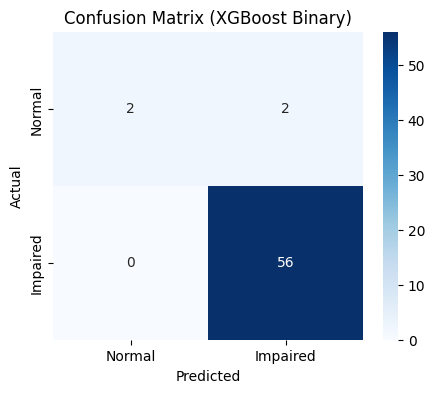

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Impaired"], yticklabels=["Normal", "Impaired"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost Binary)")
plt.show()

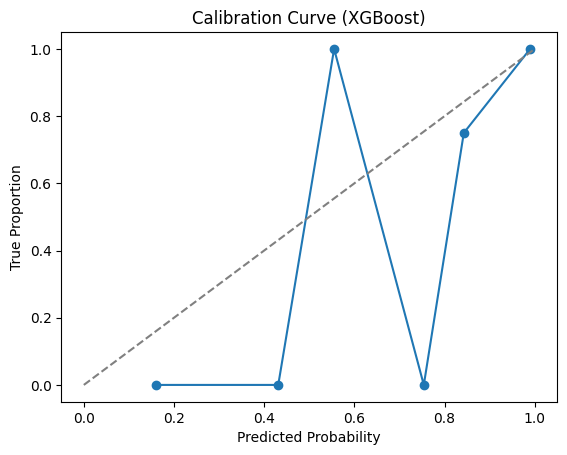

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_xgb, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',c='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Proportion")
plt.title("Calibration Curve (XGBoost)")
plt.show()

In [ ]:
def predict_vision_status(user_features):
    user = user_features.copy()
    for col in cat_cols:
        le = label_encoders[col]
        user[col] = le.transform([str(user[col])])[0]
    user_num = [user[col] for col in num_cols]
    import pandas as pd
    user_df_new = pd.DataFrame([user], columns=feature_cols)
    user_scaled = scaler.transform(user_df_new[num_cols])
    for idx, col in enumerate(num_cols):
        user[col] = user_scaled[0][idx]
    user_df_new = pd.DataFrame([user], columns=feature_cols)
    pred_prob = xgb.predict_proba(user_df_new)[0,1]
    pred = xgb.predict(user_df_new)[0]
    return {"prob_impaired": float(pred_prob), "class": ["normal", "impaired"][int(pred)]}

In [3]:
example_user = {
    "age": 20,
    "gender": "male",
    "device_type": "mobile",
    "daily_hours": 8,
    "session_length": 120,
    "breaks": 2,
    "font_size": "small",
    "brightness": "high",
    "dark_mode": "no",
    "outdoor_time": 0.5,
    "viewing_distance": 25,
    "screen_height": "eye_level",
    "lighting": "normal",
    "sleep_quality": 3,
    "headache_freq": 3,
    "eyestrain_freq": 4,
}
print("Example new user prediction:", predict_vision_status(example_user))

NameError: name 'cat_cols' is not defined